## 2 - Plate Reconstructions

In this notebook, we will explore GPlately functionalities for setting up and using a plate reconstruction model. Here, we detail how GPlately's `PlateReconstruction` object can be used to:

- Construct a plate motion model;
- Tessellate subduction zones & mid-ocean ridges; and
- Reconstruct feature geometries

The `PlateReconstruction` object contains methods to reconstruct topology features at a specific geological time. All you need to do to use this object is provide a rotation model, topology features (or feature collection) and a set of static polygons. 

To see this in action, let's first initialise all needed packages.

In [1]:
import gplately

import numpy as np
import pygplates
import glob, os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

We generate a plate reconstruction model using data from a study by Muller et al. (2019) (Source: https://www.earthbyte.org/muller-et-al-2019-deforming-plate-reconstruction-and-seafloor-age-grids-tectonics/). 

The `DataServer` object on GPlately's `download` module can be used to download data on-the-fly and store them in your system's local cache - you won't need to have local copies of files to point to anymore!

Given a string that points to a file collection (i.e. `"Muller2019"`), the modules in `DataServer` return the complete paths to all Muller et al. 2019 files needed for the `PlateReconstruction` object in a tuple. 

Let's call the `DataServer` object `gdownload`.

In [2]:
# Call GPlately's DataServer from the download.py module
gdownload = gplately.download.DataServer("Muller2019")

# Obtain all rotation files, topology features and static polygons from Muller et al. 2019
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

.gpml static files were not found. Attempting to find .shp versions instead...
Found 1 .shp version(s) of static files.


GPlately's `get_plate_reconstruction_files` method searches for .rot rotation files, .gpml topology features and .gpml static polygons. If it cannot find any relevant .gpml features, it will notify the user (as above) and search for .shp versions instead.

The "Muller2019" database only has .shp static polygons.

### Constructing a plate motion model using the `PlateReconstruction` object

Once the rotation model, topology features and static polygons have been initialised, you can simply supply them to the `PlateReconstruction` object to construct the plate motion model.

In [3]:
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

### Reconstructing feature geometries

The plate motion model we created can be used to generate plate reconstructions through geological time. Let's reconstruct subduction zones and mid-ocean ridges to 50 Ma.

In [5]:
time = 50 #Ma
subduction_data = model.tesselate_subduction_zones(time)
ridge_data = model.tesselate_mid_ocean_ridges(time)

As a quick aside, you can visualise this data on a GeoAxis plot using the `PlotTopologies` object in `Plot`, which is another GPlately module. All you need to do to use this object is supply the `PlateReconstruction` plate motion model we just created along with a specific reconstruction time (Ma). 

To see these subduction and MOR boundaries clearly, let's plot them with coastlines, continents and continent-ocean boundaries (COBs). You can obtain paths to files containing these features with GPlately's `DataServer` object too. We'll use coastlines, continents and COBs from the same Muller et al. (2019) collection.

Along with the plate motion model and reconstruction time, paths to these geometries are also main attributes of the `PlotTopologies` object.

Let's call the `PlotTopologies` object 'gplot'.

In [4]:
# Obtain geometry shapefiles with gdownload
coastlines, continents, COBs = gdownload.get_topology_geometries()

# Call the PlotTopologies object
time = 50 #Ma
gplot = gplately.plot.PlotTopologies(model, time, coastlines, continents, COBs)

.gpml coastline files were not found. Attempting to find .shp versions instead...
Found 1 .shp version(s) of coastline files.
.gpml continent files were not found. Attempting to find .shp versions instead...
Found 1 .shp version(s) of continent files.
.gpml cob files were not found. Attempting to find .shp versions instead...
Found 1 .shp version(s) of cob files.


Note: the Muller2019 data collection only has .shp coastlines, continents and COBs. GDownload will alert you if it cannot find a .gpml file.

To plot using GPlately's `PlotTopologies` object, first create a GeoAxis plot and select a projection using Cartopy. This is the plot we supply to our gplot object.

Now, let's visualise how the subduction zones (with subduction teeth!) and mid-ocean ridges look like at 50 Ma. 

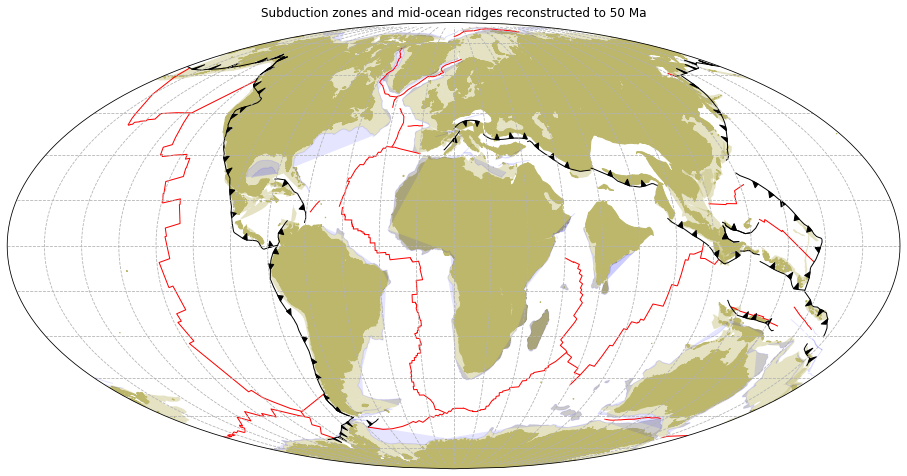

In [5]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
plt.title('Subduction zones and mid-ocean ridges reconstructed to %i Ma' % (time))

# Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
gplot.time = 50 # Ma
gplot.plot_continents(ax, facecolor='DarkKhaki', alpha=0.4)
gplot.plot_coastlines(ax, color='DarkKhaki')
gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.1)
gplot.plot_ridges_and_transforms(ax, color='red')
gplot.plot_trenches(ax, color='k')
gplot.plot_subduction_teeth(ax, color='k')

If you have moviepy available, you can create a gif that illustrates plate motions through geological time. Let's reconstruct plate movements up to 100 Ma in intervals of 10 Ma!

In [6]:
# Time variables
oldest_seed_time = 100 # Ma
time_step = 10 # Ma

# Create a plot for each 10 Ma interval
for time in np.arange(oldest_seed_time,0.,-time_step):
    
    print(f'working on time {time}')
    
    # Set up a GeoAxis plot
    fig = plt.figure(figsize=(18,10))
    ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
    ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
    plt.title('Subduction zones and mid-ocean ridges reconstructed to %i Ma' % (time))

    # Update the reconstruction time to allocate to gplot
    gplot.time = time
    
    # Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
    gplot.plot_continents(ax, facecolor='DarkKhaki', alpha=0.4)
    gplot.plot_coastlines(ax, color='DarkKhaki')
    gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.1)
    gplot.plot_ridges_and_transforms(ax, color='red')
    gplot.plot_trenches(ax, color='k')
    gplot.plot_subduction_teeth(ax, color='k')
    
    plt.savefig('/tmp/subd_mor_boundary_features_%d_Ma.png' % time)
    plt.close()
    
    print('Image for %d Ma saved' % time)

working on time 100.0
Image for 100 Ma saved
working on time 90.0
Image for 90 Ma saved
working on time 80.0
Image for 80 Ma saved
working on time 70.0
Image for 70 Ma saved
working on time 60.0
Image for 60 Ma saved
working on time 50.0
Image for 50 Ma saved
working on time 40.0
Image for 40 Ma saved
working on time 30.0
Image for 30 Ma saved
working on time 20.0
Image for 20 Ma saved
working on time 10.0
Image for 10 Ma saved


In [7]:
import moviepy.editor as mpy

frame_list = []

for time in np.arange(oldest_seed_time,0.,-time_step):
    frame_list.append('/tmp/subd_mor_boundary_features_%d_Ma.png' % time)
    

clip = mpy.ImageSequenceClip(frame_list, fps=5)
clip.write_gif('/tmp/subd_mor_boundary_features.gif')

MoviePy - Building file /tmp/subd_mor_boundary_features.gif with imageio.


The movie will show up in a few seconds. Please be patient...


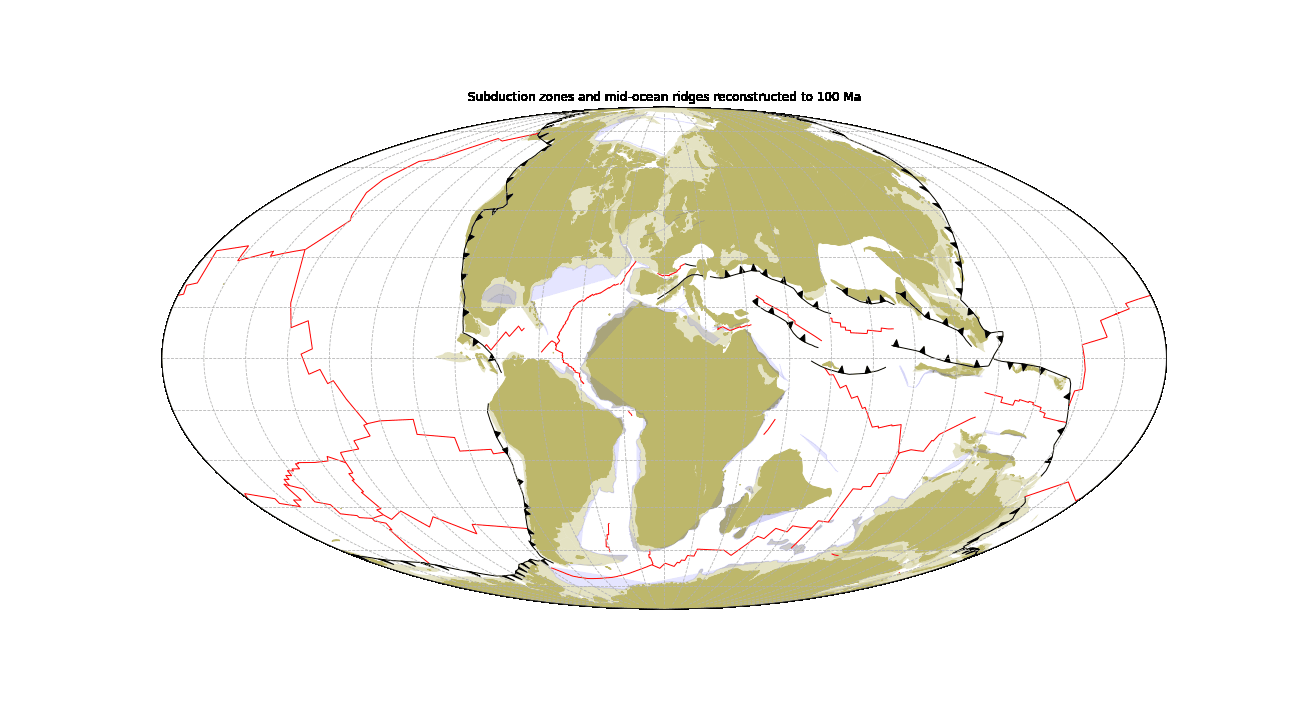

In [8]:
from IPython.display import Image
print('The movie will show up in a few seconds. Please be patient...')
with open('/tmp/subd_mor_boundary_features.gif','rb') as f:
    display(Image(data=f.read(), format='png', width = 2000, height = 500))